In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'
# device='cpu'
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

In [2]:
f = open(datadir+"original/ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]

# open the .txt file which have names of test videos
f = open(datadir+"original/ucfTrainTestlist/testlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]

In [3]:
# creating tags
train_video_tag = []
for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])
    
train['tag'] = train_video_tag

test_video_tag = []
for i in range(test.shape[0]):
    test_video_tag.append(test['video_name'][i].split('/')[0])
    
test['tag'] = test_video_tag

allVids = train.append(test, ignore_index=True)

In [4]:
imageSize=[89,89]

In [5]:
# # storing the frames from training videos
# all_image = []
# for i in tqdm(range(allVids.shape[0])):
#     count = 0
#     videoFile = allVids['video_name'].iloc[i]
#     cap = cv2.VideoCapture(datadir + 'original/UCF/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
#     frameRate = 1 #frame sample rate
#     frames = []
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     clip = []
#     for f in range(23):
#         image = frames[f]
#         image = Image.fromarray(image , 'RGB')
#         image = crop_center(np.array(image), imageSize[0], imageSize[0])
#         image = image/255
#         image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#         clip.append(image)
#     all_image.append(np.array(clip))
# all_image_crop = np.stack(all_image)    

In [6]:
# # storing the frames from training videos
# all_image = []
# for i in tqdm(range(allVids.shape[0])):
#     count = 0
#     videoFile = allVids['video_name'].iloc[i]
#     cap = cv2.VideoCapture(datadir + 'original/UCF/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
#     frameRate = 1 #frame sample rate
#     frames = []
#     while(cap.isOpened()):
#         frameId = cap.get(1) #current frame number
#         ret, frame = cap.read()
#         if (ret != True):
#             break
#         if (frameId % math.floor(frameRate) == 0):
#             frames.append(frame)
#             count+=1
#     cap.release()
#     frames = np.stack(frames)
#     clip = []
#     for f in range(23):
#         image = frames[f]
#         image = Image.fromarray(image , 'RGB')
#         image = image.resize(imageSize)
#         image = np.array(image)/255
#         image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#         clip.append(image)
#     all_image.append(np.array(clip))
# all_image = np.stack(all_image)    

In [7]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_FFR23_89x89_crop.npy',all_image_crop)

In [8]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_FFR23_89x89.npy',all_image)
all_image = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_FFR23_89x89.npy')
all_image_crop = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_FFR23_89x89_crop.npy')

In [9]:
labels = np.array(pd.get_dummies(allVids['tag']))

In [10]:
imageSize=(23,89,89)

In [11]:
def test(net, X, X_dual, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0],batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    top5 = 0
    top10 = 0
    with torch.no_grad():
        for i in range(0,testingSeq.shape[0]-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,1,*imageSize).to(device)
            data_dual = X_dual[testingSeq[i]:testingSeq[i+1]].view(-1,1,*imageSize).to(device)
            out = net(data,data_dual).cpu()
            out1 = out.argsort(axis=1, descending=True)[:, :1].flatten()
            out5 = out.argsort(axis=1, descending=True)[:, :5]
            out10 = out.argsort(axis=1, descending=True)[:, :10]           
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for i,label in enumerate(yt):                
                if label in out5[i]:
                    top5 += 1
                if label in out10[i]:
                    top10 += 1
            for pred,label in zip(out1,yt):
                confusionMatrix[label][pred] +=1
    del data
    del out
    del out1, out5, out10
    del yt
    return (confusionMatrix, top5, top10, y.shape[0])

In [12]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convRescale = nn.Conv3d(1, 180, (5,11,11), stride=(1,2,2), bias=False)
#         self.convRescale1 = nn.Conv3d(80, 180, (5,7,7), stride=(1,2,2), bias=False)
        self.conv2 = nn.Conv3d(180, 180, (1,5,5))
        self.conv3 = nn.Conv3d(180, 180, (1,5,5))
        self.conv4 = nn.Conv3d(180, 180, (1,5,5))
        self.conv5 = nn.Conv3d(180, 180, (1,5,5))
        self.conv6 = nn.Conv3d(180, 180, (1,3,3))
        self.conv7 = nn.Conv3d(180, 180, (1,3,3))
        self.conv8 = nn.Conv3d(180, 180, (1,3,3))
        self.conv9 = nn.Conv3d(180, 180, (1,3,3))
        self.conv10 = nn.Conv3d(180, 360, (3,3,3))
        self.conv11 = nn.Conv3d(360, 360, (3,3,3))
        self.conv12 = nn.Conv3d(360, 360, (3,3,3))
        
        self.batchConv1 = nn.BatchNorm3d(180)
        self.batchConv2 = nn.BatchNorm3d(180)
        self.batchConv3 = nn.BatchNorm3d(180)
        self.batchConv4 = nn.BatchNorm3d(180)
        self.batchConv5 = nn.BatchNorm3d(360)
        self.batchConv6 = nn.BatchNorm3d(360)
        self.batchConv7 = nn.BatchNorm3d(360)
        
        self.up = nn.Upsample((19,20,20),mode='trilinear',align_corners=False)
        
        x= torch.randn(1,1,23,89,89)
        self._to_linear = None
        self.convs(x)
        
        ##################
        
        self.convRescale_dual = nn.Conv3d(1, 180, (5,11,11), stride=(1,2,2), bias=False)
#         self.convRescale1 = nn.Conv3d(80, 180, (5,7,7), stride=(1,2,2), bias=False)
        self.conv2_dual = nn.Conv3d(180, 180, (1,5,5))
        self.conv3_dual = nn.Conv3d(180, 180, (1,5,5))
        self.conv4_dual = nn.Conv3d(180, 180, (1,5,5))
        self.conv5_dual = nn.Conv3d(180, 180, (1,5,5))
        self.conv6_dual = nn.Conv3d(180, 180, (1,3,3))
        self.conv7_dual = nn.Conv3d(180, 180, (1,3,3))
        self.conv8_dual = nn.Conv3d(180, 180, (1,3,3))
        self.conv9_dual = nn.Conv3d(180, 180, (1,3,3))
        self.conv10_dual = nn.Conv3d(180, 360, (3,3,3))
        self.conv11_dual = nn.Conv3d(360, 360, (3,3,3))
        self.conv12_dual = nn.Conv3d(360, 360, (3,3,3))
        
        self.batchConv1_dual = nn.BatchNorm3d(180)
        self.batchConv2_dual = nn.BatchNorm3d(180)
        self.batchConv3_dual = nn.BatchNorm3d(180)
        self.batchConv4_dual = nn.BatchNorm3d(180)
        self.batchConv5_dual = nn.BatchNorm3d(360)
        self.batchConv6_dual = nn.BatchNorm3d(360)
        self.batchConv7_dual = nn.BatchNorm3d(360)
        
        self.up_dual = nn.Upsample((19,20,20),mode='trilinear',align_corners=False)
        
        x= torch.randn(1,1,23,89,89)
        self._to_linear_dual = None
        self.convs_dual(x)
        
        self.fc1 = nn.Linear(self._to_linear + self._to_linear_dual, 101)
        
        self.batch1 = nn.BatchNorm1d(101)
        
        
    def convs(self, x):
        x = F.leaky_relu(F.max_pool3d(self.convRescale(x),(1,2,2)))
#         print(x.shape)
#         x = F.relu(self.convRescale1(x))
        inp2 = x
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.batchConv1(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.batchConv2(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        x = self.batchConv3(x)
        x = self.up(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.leaky_relu(self.conv8(x))
        x = F.leaky_relu(self.conv9(x))
        x = self.batchConv4(x)
        x = self.up(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.leaky_relu(F.max_pool3d(self.conv10(x),(1,3,3)))
        x = self.batchConv5(x)
        x = F.leaky_relu(self.conv11(x))
        x = self.batchConv6(x)
        x = F.leaky_relu(F.max_pool3d(self.conv12(x),(1,2,2)))
        x = self.batchConv7(x)
#         print(x.shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x

    def convs_dual(self, x):
        x = F.leaky_relu(F.max_pool3d(self.convRescale_dual(x),(1,2,2)))
#         print(x.shape)
#         x = F.relu(self.convRescale1(x))
        inp2 = x
        x = F.leaky_relu(self.conv2_dual(x))
        x = F.leaky_relu(self.conv3_dual(x))
        x = self.batchConv1_dual(x)
        x = self.up_dual(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.leaky_relu(self.conv4_dual(x))
        x = F.leaky_relu(self.conv5_dual(x))
        x = self.batchConv2_dual(x)
        x = self.up_dual(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.leaky_relu(self.conv6_dual(x))
        x = F.leaky_relu(self.conv7_dual(x))
        x = self.batchConv3_dual(x)
        x = self.up_dual(x)
        inp1 = x
        x+=inp2
        del inp2
        x = F.leaky_relu(self.conv8_dual(x))
        x = F.leaky_relu(self.conv9_dual(x))
        x = self.batchConv4_dual(x)
        x = self.up_dual(x)
        inp2 = x
        x+=inp1
        del inp1
        x = F.leaky_relu(F.max_pool3d(self.conv10_dual(x),(1,3,3)))
        x = self.batchConv5_dual(x)
        x = F.leaky_relu(self.conv11_dual(x))
        x = self.batchConv6_dual(x)
        x = F.leaky_relu(F.max_pool3d(self.conv12_dual(x),(1,2,2)))
        x = self.batchConv7_dual(x)
#         print(x.shape)
        
        if self._to_linear_dual is None:
            self._to_linear_dual = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x,x_dual):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x_dual = self.convs_dual(x_dual)        
        x_dual = x_dual.view(-1, self._to_linear_dual)
        x=torch.cat((x,x_dual),axis=1)
        del x_dual
        x = self.fc1(x)
        self.batch1(x)
        return F.softmax(x, dim=1)

In [13]:
filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_5x11x11_movAndRot180.npy', allow_pickle=True)
# filters180 = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_577_movAndRot180.npy', allow_pickle=True)

In [14]:
EPOCHS = 100
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

for foldIndex in range(3):
    
    net = ResNet().to(device)
    optimizer = optim.AdamW(net.parameters(), lr=3e-5)

    ## Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(filters):
            net.convRescale.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
            net.convRescale_dual.weight[i] = torch.nn.Parameter(torch.tensor(weights)).to(device)
        net.convRescale_dual.requires_grad=False
#         for i,weights in enumerate(filters):
#             net.convRescale1.weight[:,i,...] = torch.nn.Parameter(torch.tensor(filters180)).to(device)
#         net.convRescale1.requires_grad=False

    print('Network Reset.')  

    X_train, X_test, y_train, y_test = train_test_split(all_image, labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=.33, stratify = labels)
    X_train_crop, X_test_crop, y_train, y_test = train_test_split(all_image_crop, labels,
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=.33, stratify = labels)

    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_train_crop = torch.tensor(X_train_crop,dtype=torch.float32)
    y_train = torch.tensor(y_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    X_test_crop =  torch.tensor(X_test_crop,dtype=torch.float32)
    y_test = torch.tensor(y_test,dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X=X.to(device)
            X_crop=X_train_crop[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,*imageSize)
            X_crop=X_crop.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X,X_crop)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del X_crop
            del y

        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test,X_test_crop, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1][0]
        print('Top1 Acc: ' , np.sum(np.diag(cm))/np.sum(cm))
#         print('Top5 Acc: ' , results[foldIndex][len(results[foldIndex])-1][1]/results[0][0][3])
#         print('Top10 Acc: ' , results[foldIndex][len(results[foldIndex])-1][2]/results[0][0][3])

np.save('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_highacc_DH_norm_100_res_3fold_tops.npy', results)
np.save('/home/ephy/Projects/tda_convolve_video/data/altered/UCF_highacc_DH_norm_100_loss_3fold_tops.npy', lossrec)

Network Reset.
Fold:  0 Epoch:  0
Top1 Acc:  0.1994995450409463
Fold:  0 Epoch:  1
Top1 Acc:  0.3032302092811647
Fold:  0 Epoch:  2
Top1 Acc:  0.39490445859872614
Fold:  0 Epoch:  3
Top1 Acc:  0.4597361237488626
Fold:  0 Epoch:  4
Top1 Acc:  0.5072793448589626
Fold:  0 Epoch:  5
Top1 Acc:  0.5348043676069154
Fold:  0 Epoch:  6
Top1 Acc:  0.5630118289353958
Fold:  0 Epoch:  7
Top1 Acc:  0.5850773430391265
Fold:  0 Epoch:  8
Top1 Acc:  0.5882620564149227
Fold:  0 Epoch:  9
Top1 Acc:  0.6146496815286624
Fold:  0 Epoch:  10
Top1 Acc:  0.6185168334849863
Fold:  0 Epoch:  11
Top1 Acc:  0.6314831665150137
Fold:  0 Epoch:  12
Top1 Acc:  0.6344404003639672
Fold:  0 Epoch:  13
Top1 Acc:  0.6419472247497725
Fold:  0 Epoch:  14
Top1 Acc:  0.6437670609645132
Fold:  0 Epoch:  15
Top1 Acc:  0.6487716105550501
Fold:  0 Epoch:  16
Top1 Acc:  0.6403548680618745
Fold:  0 Epoch:  17
Top1 Acc:  0.6169244767970883
Fold:  0 Epoch:  18
Top1 Acc:  0.6239763421292084
Fold:  0 Epoch:  19
Top1 Acc:  0.64217470427

Fold:  1 Epoch:  64
Top1 Acc:  0.6712920837124658
Fold:  1 Epoch:  65
Top1 Acc:  0.6669699727024567
Fold:  1 Epoch:  66
Top1 Acc:  0.6267060964513194
Fold:  1 Epoch:  67
Top1 Acc:  0.6562784349408554
Fold:  1 Epoch:  68
Top1 Acc:  0.6626478616924477
Fold:  1 Epoch:  69
Top1 Acc:  0.666287534121929
Fold:  1 Epoch:  70
Top1 Acc:  0.6687898089171974
Fold:  1 Epoch:  71
Top1 Acc:  0.6703821656050956
Fold:  1 Epoch:  72
Top1 Acc:  0.6719745222929936
Fold:  1 Epoch:  73
Top1 Acc:  0.6305732484076433
Fold:  1 Epoch:  74
Top1 Acc:  0.6287534121929026
Fold:  1 Epoch:  75
Top1 Acc:  0.6528662420382165
Fold:  1 Epoch:  76
Top1 Acc:  0.658098271155596
Fold:  1 Epoch:  77
Top1 Acc:  0.6615104640582348
Fold:  1 Epoch:  78
Top1 Acc:  0.6624203821656051
Fold:  1 Epoch:  79
Top1 Acc:  0.6637852593266605
Fold:  1 Epoch:  80
Top1 Acc:  0.664695177434031
Fold:  1 Epoch:  81
Top1 Acc:  0.666287534121929
Fold:  1 Epoch:  82
Top1 Acc:  0.6671974522292994
Fold:  1 Epoch:  83
Top1 Acc:  0.6631028207461328
Fold

In [3]:
results = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_highacc_k1_100_res_3fold_tops.npy',allow_pickle=True)
lossrec = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_highacc_k1_100_loss_3fold_tops.npy',allow_pickle=True)
results_norm = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_highacc_norm_100_res_3fold_tops.npy',allow_pickle=True)
lossrec_norm = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/KTH_highacc_norm_100_res_3fold_tops.npy',allow_pickle=True)

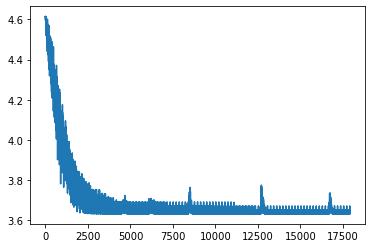

In [4]:
plt.plot(lossrec[0])

In [ ]:
### Comparing topNs

a1: 0.71
b1: 0.86
c1: 0.91
a2: 0.57
b2: 0.72
c2: 0.79


/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


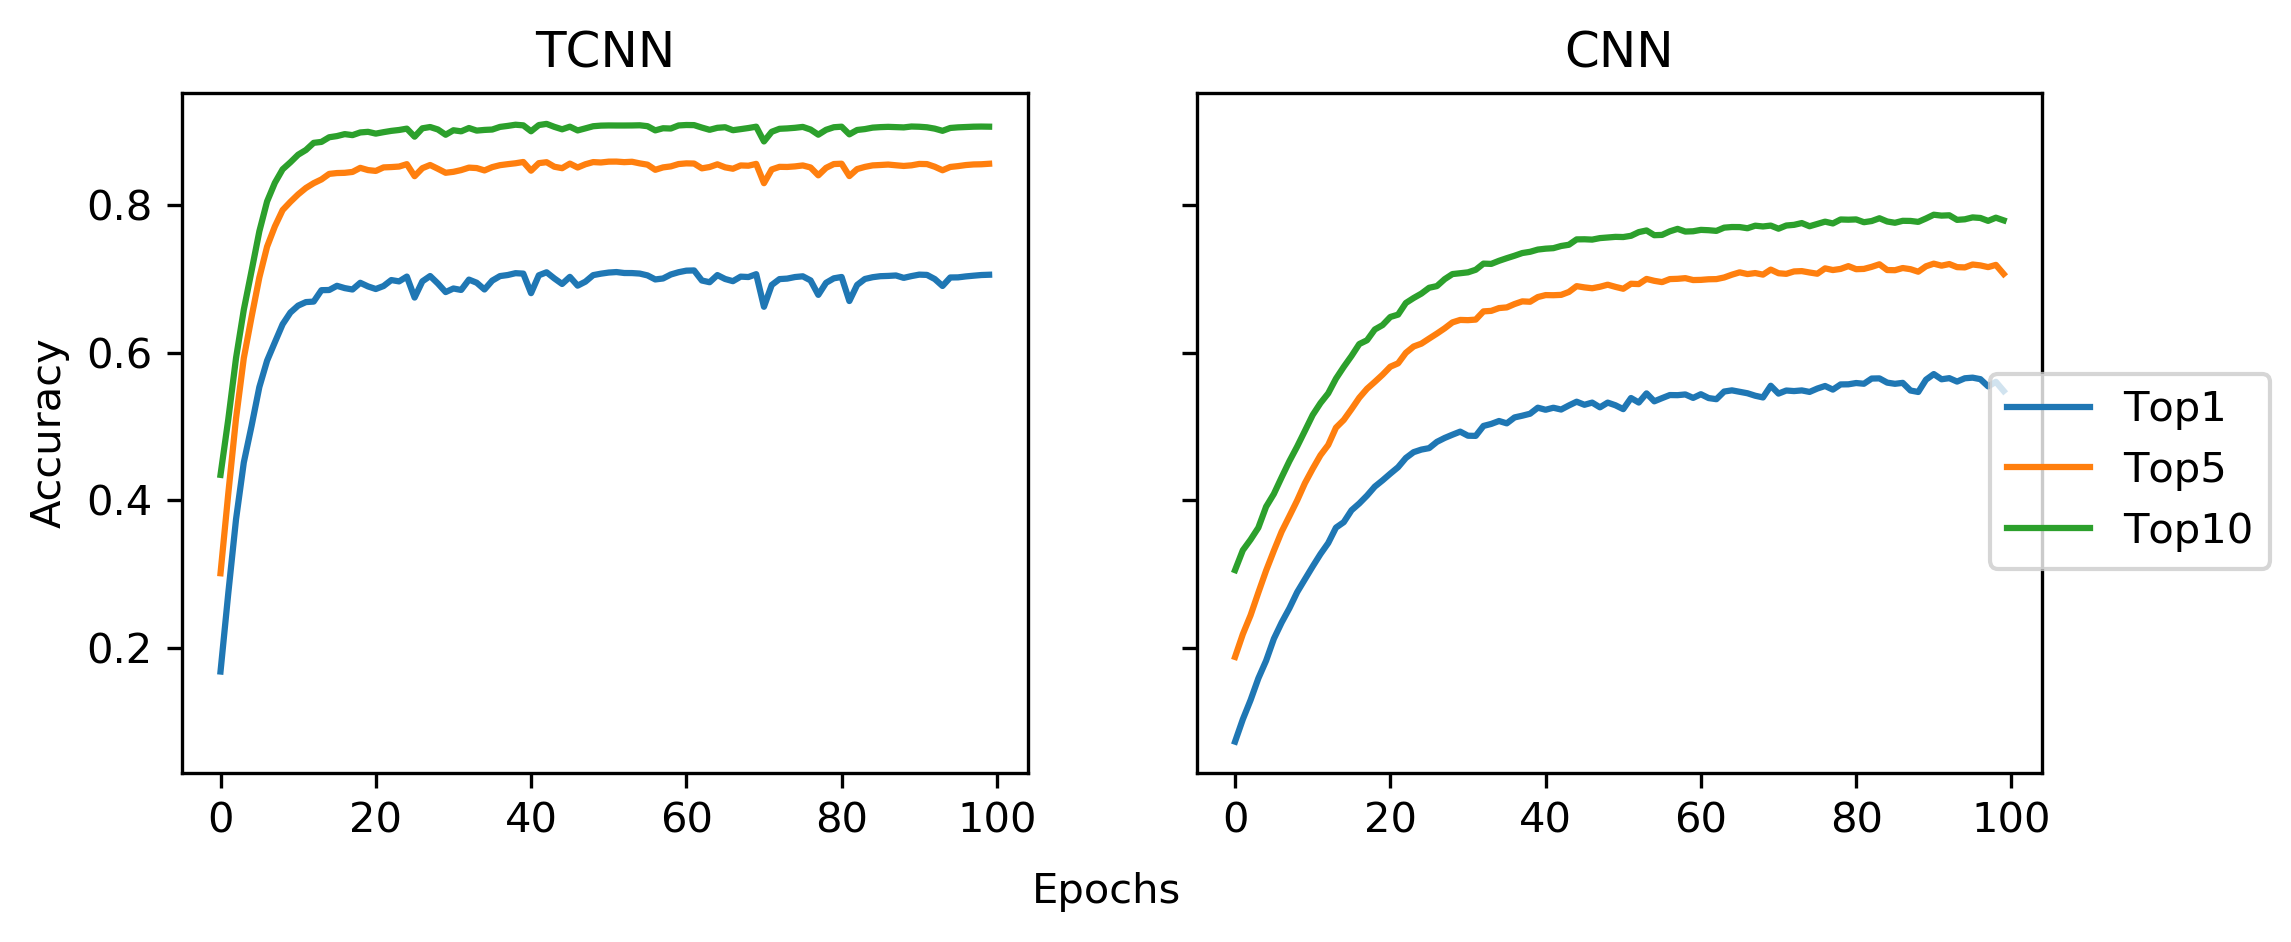

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True,sharex=True,figsize=(8,3), dpi= 300)
a = np.array([[np.sum(np.diag(r[0]))/np.sum(r[0]) for r in result] for result in results])
b = np.array([[r[1]/r[3] for r in result] for result in results])
c = np.array([[r[2]/r[3] for r in result] for result in results])
ax1.plot(np.mean(a,axis=0), label='Top1')
ax1.plot(np.mean(b,axis=0), label='Top5')
ax1.plot(np.mean(c,axis=0), label='Top10')
ax1.set_ylabel('Accuracy')
ax1.set_title('TCNN')
print('a1:',round(np.max(np.mean(a,axis=0)),2))
print('b1:',round(np.max(np.mean(b,axis=0)),2))
print('c1:',round(np.max(np.mean(c,axis=0)),2))
# ax1.set_xlabel('Epochs')

a = np.array([[np.sum(np.diag(r[0]))/np.sum(r[0]) for r in result] for result in results_norm])
b = np.array([[r[1]/r[3] for r in result] for result in results_norm])
c = np.array([[r[2]/r[3] for r in result] for result in results_norm])
ax2.plot(np.mean(a,axis=0))
ax2.plot(np.mean(b,axis=0))
ax2.plot(np.mean(c,axis=0))
ax2.set_title('CNN')
# ax2.set_xlabel('Epochs')

print('a2:',round(np.max(np.mean(a,axis=0)),2))
print('b2:',round(np.max(np.mean(b,axis=0)),2))
print('c2:',round(np.max(np.mean(c,axis=0)),2))

fig.text(0.51, -0.02, 'Epochs', ha='center')

fig.legend(loc='center right')
fig.show()

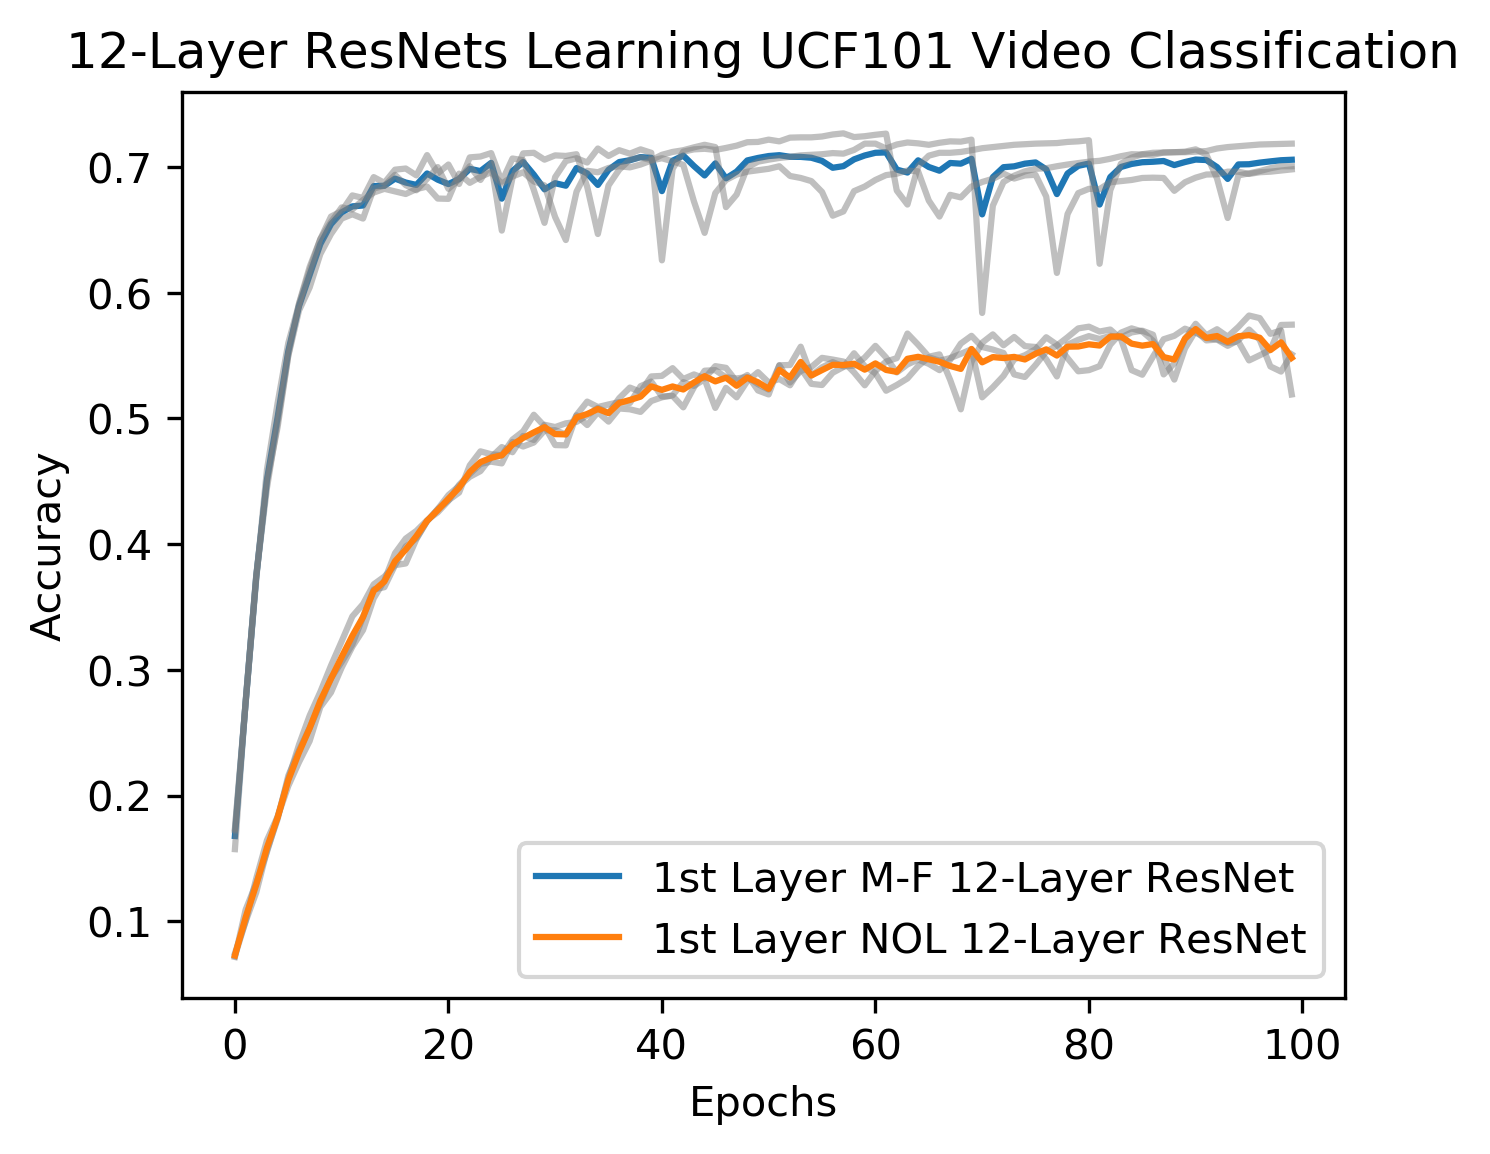

In [6]:
a = np.array([[np.sum(np.diag(r[0]))/np.sum(r[0]) for r in result] for result in results])
plt.figure(figsize=(5,4), dpi=300)
plt.plot(np.mean(a,axis=0), label='1st Layer M-F 12-Layer ResNet')
for l in a:
    plt.plot(l,color='gray', alpha=.5)
# plt.plot(np.mean(a,axis=0)-1*np.std(a, axis=0),color='gray', linestyle='--')
# plt.plot(np.mean(a,axis=0)+1*np.std(a, axis=0),color='gray', linestyle='--')

b = np.array([[np.sum(np.diag(r[0]))/np.sum(r[0]) for r in result] for result in results_norm])
for l in b:
    plt.plot(l,color='gray', alpha=.5)
plt.plot(np.mean(b,axis=0), label='1st Layer NOL 12-Layer ResNet')
# plt.plot(np.mean(b,axis=0)-1*np.std(b, axis=0),color='gray', linestyle='--')
# plt.plot(np.mean(b,axis=0)+1*np.std(b, axis=0),color='gray', linestyle='--')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('12-Layer ResNets Learning UCF101 Video Classification')
plt.show()


In [148]:
a = np.array([[np.min(np.diag(r[0])/np.sum(r[0],axis=0)) for r in result] for result in results])
print(a)
print('worst k:',np.mean(np.max(a,axis=1)))
a = np.array([[np.max(np.diag(r[0])/np.sum(r[0],axis=0)) for r in result] for result in results])
print('best n:',np.mean(np.max(a,axis=1)))

b = np.array([[np.min(np.diag(r[0])/np.sum(r[0],axis=0)) for r in result] for result in results_norm])
print('worst n:',np.mean(np.max(b,axis=1)))
b = np.array([[np.max(np.diag(r[0])/np.sum(r[0],axis=0)) for r in result] for result in results_norm])
print('best n:',np.mean(np.max(b,axis=1)))



[[[       nan 0.18181818        nan ...        nan        nan        nan]
  [1.         0.23966942        nan ...        nan 0.35416667 1.        ]
  [0.43243243 0.36842105        nan ... 0.4375     0.44444444 1.        ]
  ...
  [0.73076923 0.77272727 0.9        ... 0.95238095 0.63076923 0.69444444]
  [0.73076923 0.77272727 0.9        ... 0.95238095 0.65079365 0.7027027 ]
  [0.73076923 0.77272727 0.9        ... 0.95238095 0.640625   0.7027027 ]]

 [[       nan        nan        nan ... 0.6        0.13793103        nan]
  [0.17       1.                nan ... 0.30379747 0.26582278        nan]
  [0.34567901 0.36585366        nan ... 0.36       0.30985915 0.48387097]
  ...
  [0.84444444 0.71698113 0.87804878 ... 0.8125     0.70909091 0.65384615]
  [0.84444444 0.71698113 0.87804878 ... 0.8125     0.70909091 0.65384615]
  [0.84444444 0.71698113 0.87804878 ... 0.8125     0.70909091 0.65384615]]

 [[       nan 0.2        0.77777778 ... 0.140625          nan        nan]
  [0.         0.461538

/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/ephy/anaconda3/envs/opencvenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [162]:
cm = results[0][99][0]
print('Best k:',round(np.max(np.diag(cm)/np.sum(cm,axis=0)),2))
print('50% k:',round(np.sort(np.diag(cm)/np.sum(cm,axis=0))[50],2))
print('Worst k:', round(np.min(np.diag(cm)/np.sum(cm,axis=0)),2))
print('Mean k:', round(np.mean(np.diag(cm)/np.sum(cm,axis=0)),2))
print('SD k:', round(np.std(np.diag(cm)/np.sum(cm,axis=0)),2))

cm = results_norm[0][99][0]
print('Best n:',round(np.max(np.diag(cm)/np.sum(cm,axis=0)),2))
print('50% n:',round(np.sort(np.diag(cm)/np.sum(cm,axis=0))[50],2))
print('Worst n:', round(np.min(np.diag(cm)/np.sum(cm,axis=0)),2))
print('Mean n:', round(np.mean(np.diag(cm)/np.sum(cm,axis=0)),2))
print('SD n:', round(np.std(np.diag(cm)/np.sum(cm,axis=0)),2))




Best k: 0.98
50% k: 0.7
Worst k: 0.26
Mean k: 0.69
SD k: 0.15
Best n: 0.98
50% n: 0.53
Worst n: 0.14
Mean n: 0.57
SD n: 0.17
